In [1]:

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tensorflow import keras
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # resolution
directory = "/content/drive/MyDrive/major dataset/Rice Seed Dataset"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='training',
    color_mode='rgb',
    seed=42
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='validation',
    color_mode='rgb',
    seed=42
)


Found 1011 files belonging to 2 classes.
Using 809 files for training.
Found 1011 files belonging to 2 classes.
Using 202 files for validation.


In [5]:
class_names= ["overwater" ,"underwater"]

In [6]:
plt.figure(figsize=(20,20))
for images , labels in train_dataset.take(1):
    for i in range(20):
        plt.subplot(5,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[labels[i]])


Output hidden; open in https://colab.research.google.com to view.

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
IMG_SHAPE = IMG_SIZE +(3,)
ResNet_Model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE, include_top= True,weights='imagenet')

102869336/102869336 [==============================] - 1s 0us/step


In [9]:
ResNet_Model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [10]:
type(ResNet_Model)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input #data preprocessing using the same weights the model was trained on


In [11]:
nb_layers = len(ResNet_Model.layers)
print("Numbers of Layers =" , nb_layers)
print(ResNet_Model.layers[nb_layers - 2].name)  # pre- Last name
print(ResNet_Model.layers[nb_layers - 1].name)  # Last Layer name
# Last two layers are called top layers (Classification)

Numbers of Layers = 192
avg_pool
predictions


In [12]:
# iterate over first batch (32 image) in trainset
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays
feature_batch = ResNet_Model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(32, 1000)


In [13]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1], dtype=int32)>

In [14]:
def rice_leaf_model( image_shape=IMG_SIZE):
    ''' Define a tf.keras model for multi-class classification out of the InceptionV3 model '''
    image_shape = image_shape + (3,)

    resnet_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
    resnet_model.trainable = False
    inputs = tf.keras.Input(image_shape)
    x = preprocess_input(inputs)
    x = resnet_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    prediction_layer = tf.keras.layers.Dense(1)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [15]:
Rice_Leaf_Model = rice_leaf_model(IMG_SIZE)

94668760/94668760 [==============================] - 0s 0us/step


In [16]:
base_learning_rate = 0.04
Rice_Leaf_Model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
history = Rice_Leaf_Model.fit(train_dataset , verbose=2 , epochs=10 , validation_data=validation_dataset)

Epoch 1/10
26/26 - 303s - loss: 0.7722 - accuracy: 0.5117 - val_loss: 0.6032 - val_accuracy: 0.7277 - 303s/epoch - 12s/step
Epoch 2/10
26/26 - 274s - loss: 0.5723 - accuracy: 0.6700 - val_loss: 0.5118 - val_accuracy: 0.7525 - 274s/epoch - 11s/step
Epoch 3/10
26/26 - 251s - loss: 0.4969 - accuracy: 0.7602 - val_loss: 0.4737 - val_accuracy: 0.7376 - 251s/epoch - 10s/step
Epoch 4/10
26/26 - 252s - loss: 0.4689 - accuracy: 0.7651 - val_loss: 0.4591 - val_accuracy: 0.7475 - 252s/epoch - 10s/step
Epoch 5/10
26/26 - 253s - loss: 0.4373 - accuracy: 0.7763 - val_loss: 0.4507 - val_accuracy: 0.7723 - 253s/epoch - 10s/step
Epoch 6/10
26/26 - 205s - loss: 0.4310 - accuracy: 0.7960 - val_loss: 0.4597 - val_accuracy: 0.7426 - 205s/epoch - 8s/step
Epoch 7/10
26/26 - 204s - loss: 0.4027 - accuracy: 0.8084 - val_loss: 0.4393 - val_accuracy: 0.7673 - 204s/epoch - 8s/step
Epoch 8/10
26/26 - 211s - loss: 0.3770 - accuracy: 0.8158 - val_loss: 0.4319 - val_accuracy: 0.7723 - 211s/epoch - 8s/step
Epoch 9/10


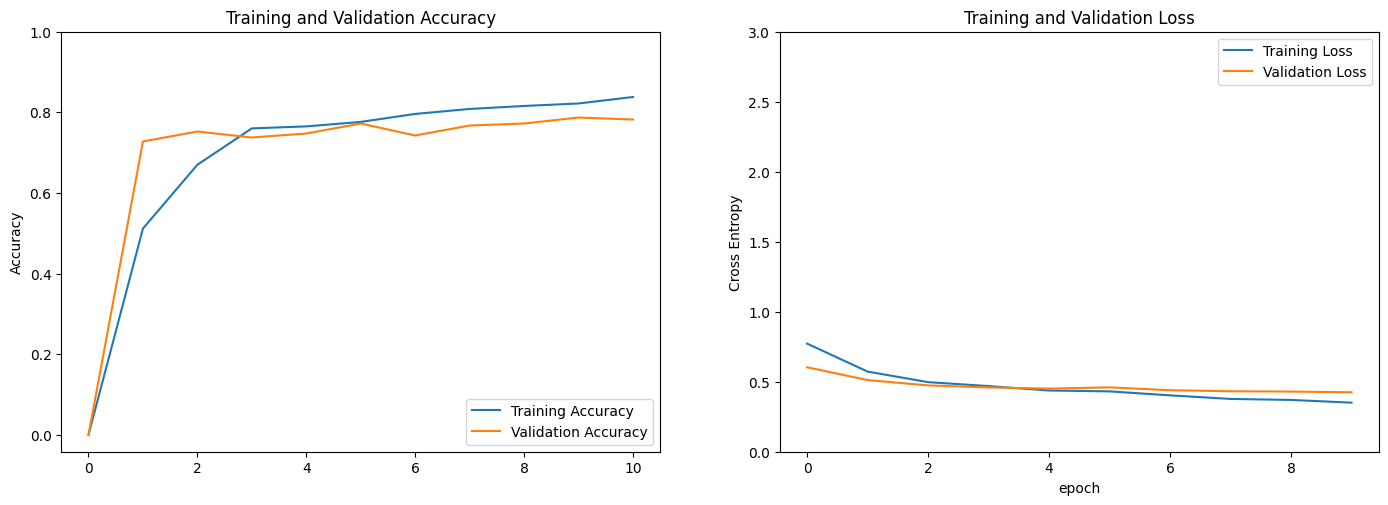

In [18]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()